**Training models on Covariance matrix and mean matrix of the MFCC of audio samples**

The Covariance matrix and mean matrix was found in the Music Genre Classification Notebook, and will bw used to train several models here.

Models:
- Logistic Regression?
- Convolutional Neural Network
    - Did not work well using the covariance matrix, so the Mel Spectrogram was used in the "Models using Mel Spectrogram" notebook

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import math, random, pickle, os, operator
from tempfile import TemporaryFile

from scipy.io import wavfile
from python_speech_features import mfcc
%matplotlib inline

In [2]:
## Use GPU support
# needed to prevent error from using too much gpu memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


Load Data

In [3]:
# loading data - could try converting to pandas Dataframe instead
dataset = []
train = []
test = []
with open("feat.dat", 'rb') as f:
    while True:
        try:
            dataset.append(pickle.load(f))
        except EOFError:
            f.close()
            break
    


In [4]:
# convert data to Pandas DataFrame
flattened = []
for x in dataset:   
    flattened.append(list(x[0]) + list(x[1].flatten()) + [x[2]])

cols = [['m' +str(i) for i in range(13)]+['c'+str(i) for i in range(169)]+["Genre"]]
df = pd.DataFrame(flattened, columns=cols)
    

In [5]:
df.head()


,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,...,c160,c161,c162,c163,c164,c165,c166,c167,c168,Genre
0,76.502611,-1.961417,-15.774347,3.831419,-10.473326,1.311828,-19.393732,5.286790,-16.631725,5.353444,...,3.786696,-0.021175,-14.523117,-12.995331,-3.843489,-14.831619,2.251195,29.282607,64.650762,1
1,66.931650,0.718853,-3.267830,4.181200,-8.050941,6.448259,-17.768517,14.091810,-18.332536,3.685560,...,-16.026806,-13.013754,18.476615,11.603178,-3.788941,-17.738734,-8.665845,18.410328,90.762876,1
2,78.774103,3.039700,-19.024435,-0.983591,-14.699337,7.586562,-12.823053,1.892920,-14.865326,3.595252,...,-18.087720,-6.627783,-2.016122,-12.890326,-3.702126,-3.862404,0.221521,-9.624113,83.777252,1
3,66.696107,9.211514,-4.532876,5.027148,-8.254011,8.101201,-9.676610,9.824043,-6.735213,10.332956,...,-21.272778,-13.864303,13.764830,4.091590,-5.564044,-11.718776,-10.097750,4.902070,69.758813,1
4,71.972846,0.506410,-23.834838,-2.181944,-29.875498,0.719521,-19.039014,-1.353935,-13.370416,5.069944,...,-15.531564,9.558282,14.068872,-4.271712,-29.419962,13.653176,6.385477,7.264809,102.319498,1


The model now has 183 features and 1000 training examples
- 13 - mean for each cepstral coefficient
- 169 - elements of 13x13 covariance matrix
- 1 - genre label (1-10)

**FEATURE ANALYSIS**

Ideas:
- Split data into training and test data (and randomize)
- normalise values

In [84]:
# split into train and test data with separate labels:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],df[["Genre"]], test_size=0.1, random_state=420)

In [87]:
# normalisation
# min and max processor
min_max_scaler = preprocessing.MinMaxScaler()
train_scaled = min_max_scaler.fit_transform(X_train)
test_scaled = min_max_scaler.fit_transform(X_test)
# apply normalizer
X_trainn = pd.DataFrame(train_scaled)
X_testn = pd.DataFrame(test_scaled)

X_trainn.columns = X_train.columns
X_testn.columns = X_test.columns


<strong>Models</strong>

**Logistic Regression**
- Accuracy of 65% using:
LogisticRegression(random_state=2, solver='lbfgs', multi_class='ovr', max_iter=8000)


In [112]:
# Create and fit model
linRegr = LogisticRegression(random_state=2, solver='lbfgs', multi_class='ovr', max_iter=1000)
linRegr.fit(X_trainn, y_train.values.ravel())

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=2)

In [124]:
# Using validation curve
train_sizes, train_scores, valid_scores = learning_curve(linRegr, X_trainn, y_train.values.ravel(),
                                                        train_sizes=np.linspace(150,700,50, dtype=int),cv=5,
                                                        scoring = 'neg_mean_squared_error')

In [125]:
train_scores_mean = -train_scores.mean(axis=1)
valid_scores_mean =-valid_scores.mean(axis=1)

In [126]:
train_scores_mean

array([2.82133333, 2.69565217, 2.72209302, 2.83606557, 3.04226804,
       3.26213592, 2.88940092, 3.31403509, 3.08953975, 3.41434263,
       3.08167939, 2.9047619 , 3.09577465, 3.35322034, 3.76872964,
       4.02955975, 4.09544073, 3.91588235, 4.12329545, 4.0738292 ,
       4.10748663, 4.33766234, 4.24444444, 4.19460784, 4.43054893,
       4.33767442, 4.13514739, 4.22825607, 4.46724138, 4.36715789,
       4.39917695, 4.30462777, 4.48565815, 4.52461538, 4.42259887,
       4.48228782, 4.56245487, 4.44035398, 4.53090278, 4.38126065,
       4.32675585, 4.29672131, 4.26344605, 4.36234177, 4.35738725,
       4.30778626, 4.26126126, 4.44549483, 4.35872093, 4.34457143])

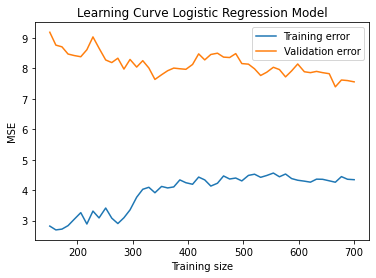

In [127]:
# plot learning curves
plt.plot(train_sizes, train_scores_mean, label = "Training error")
plt.plot(train_sizes, valid_scores_mean, label = "Validation error")
plt.xlabel("Training size")
plt.ylabel("MSE")
plt.title("Learning Curve Logistic Regression Model")
plt.legend()



From the learning curve above, it is apparent that more training data would help the validation curve converge towards the training curve and decrease error. This is done in the "Adding more data" notebook.

In [ ]:
# Add more data

In [128]:
# Predict
def accuracy(model):
    pred = model.predict(X_testn)
    return round(sum(y_test.values.ravel() == pred) / len(y_test), 6)

In [129]:
# Accuracy of logistic Regression model
print("Logistic Regression Model Accuracy: ", accuracy(linRegr))

Logistic Regression Model Accuracy:  0.65


In [130]:
linRegr.score(X_testn, y_test)

0.65

**Define Convolutional Neural Network model**
- Using Conv2D
    - need to have features in a 2D array
        - can append 



In [230]:
# convert features to 2d array 14x13
X_2d_train = np.zeros(shape=(len(X_trainn), 14,13,1))
for i in range(len(X_trainn)):
    X_2d_train[i] = X_trainn.iloc[i].to_numpy().reshape(14,13,1)

In [231]:
X_2d_train.shape

(670, 14, 13, 1)

In [238]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = X_2d_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # as it was 2D, dense needs 1D
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

model.fit(X_2d_train, y_train, batch_size=100, epochs=10, validation_split=0.1)

Epoch 1/10
7/7 [==============================] - 1s 39ms/step - loss: -2.2533 - accuracy: 0.1191 - val_loss: -11.9623 - val_accuracy: 0.0896
Epoch 2/10
7/7 [==============================] - 0s 11ms/step - loss: -17.2277 - accuracy: 0.1150 - val_loss: -43.8314 - val_accuracy: 0.0896
Epoch 3/10
7/7 [==============================] - 0s 11ms/step - loss: -58.1811 - accuracy: 0.1138 - val_loss: -122.0686 - val_accuracy: 0.0896
Epoch 4/10
7/7 [==============================] - 0s 12ms/step - loss: -151.0897 - accuracy: 0.1250 - val_loss: -292.3506 - val_accuracy: 0.0896
Epoch 5/10
7/7 [==============================] - 0s 11ms/step - loss: -364.5027 - accuracy: 0.1108 - val_loss: -627.5779 - val_accuracy: 0.0896
Epoch 6/10
7/7 [==============================] - 0s 11ms/step - loss: -741.1276 - accuracy: 0.1195 - val_loss: -1237.5494 - val_accuracy: 0.0896
Epoch 7/10
7/7 [==============================] - 0s 11ms/step - loss: -1444.7733 - accuracy: 0.1139 - val_loss: -2262.9272 - val_accur

Using covariance matrix and mean matrix in CNN didn't seem to train well at all. Instead, I'll use the Mel spectogram (MFCC before carrying out DCT) as features (seen in CNN with spectrograms Notebook).
Otherwise, I could use a different model for the mel coefficients like logistic regression, multiclass SVMs and K-means clustering.

In [197]:
X_train.shape

(670, 182)

In [204]:
np.array(dataset).shape

<ipython-input-204-2982848bd061>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(dataset).shape


(1000, 3)

(array([ 76.50261107,  -1.96141736, -15.7743469 ,   3.8314189 ,
        -10.47332553,   1.31182833, -19.39373183,   5.28678994,
        -16.63172467,   5.3534445 ,  -9.85657026,   6.25007663,
         -5.58749505]),
 array([[ 3.13643266e+01, -1.34683421e+00, -9.48272203e-01,
         -2.05382281e+01, -1.45847814e+01, -1.72347943e+01,
         -9.35145739e+00,  2.72034545e+00, -3.29035455e+00,
          1.04057336e+00,  2.32513168e+00,  6.09119695e+00,
          8.44732834e+00],
        [-1.34683421e+00,  3.64751586e+01, -2.19100677e+01,
         -1.52506981e+01, -7.71247217e+00, -1.42477860e+01,
         -6.48177523e+00,  3.95463925e+00,  1.14509487e+00,
         -4.30576920e+00,  9.05817993e+00,  8.98145706e+00,
          7.68495192e+00],
        [-9.48272203e-01, -2.19100677e+01,  7.63578328e+01,
          1.69425823e+01, -2.67611115e+01, -2.71149039e+00,
          1.99049253e+01,  1.64116110e+01, -1.31355709e+01,
          1.53609455e+01, -1.31293962e+01, -7.47897696e+00,
         -